# Hamiltonian Simulation by Matrix Arithmetic

In this notebook, we will demonstrate how we can use Qualtran's block encoding library to encode and transform data as part of a complex quantum algorithm. 

Specifically, we will study [A quantum algorithm for the linear Vlasov equation with collions](https://arxiv.org/abs/2303.03450) by Ameri et al. (2023), which simulates the dynamics of plasmas.

### Note on Speedup

As stated by the authors, this "quantum algorithm ... can yield a quadratic speedup compared to classical algorithms that solve the same system of equations. An exponential speedup, however, does not seem possible with currently known methods due to the large norm of the matrices involved."

As such, one goal of this notebook will be to perform a concrete resource estimate of the quantum algorithm to help us ascertain its speedup in practice.

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import jv

from qualtran.bloqs.basic_gates import Identity
from qualtran.bloqs.block_encoding import (
    BlockEncoding,
    ChebyshevPolynomial,
    ScaledChebyshevPolynomial,
    LinearCombination,
    Phase,
    Product,
    TensorProduct,
    Unitary,
)
from qualtran.bloqs.block_encoding.sparse_matrix import (
    SymmetricBandedRowColumnOracle,
    ExplicitEntryOracle,
    SparseMatrix,
)
from qualtran.bloqs.block_encoding.rewrites import collect_like_terms
from qualtran.bloqs.block_encoding.vlasov_equation import VlasovEntryOracle
from qualtran.bloqs.hamiltonian_simulation.hamiltonian_simulation_by_gqsp import (
    HamiltonianSimulationByGQSP,
)
from qualtran.resource_counting.generalizers import ignore_split_join
from qualtran.resource_counting.t_counts_from_sigma import t_counts_from_sigma

## Mathematical Formulation

The algorithm solves the collisional Vlasov-Poisson equation (Eq. 1 and 2 in the reference). We focus on the core of the algorithm, which solves the following ODE:

$$ \frac{d\mathbf{g}_k}{dt} = A\mathbf{g}_k $$

with solution

$$ \mathbf{g}_k(t) = e^{At} \mathbf{g}_k(t = 0) $$

where $\mathbf{g}_k(0)$ is the initial condition and $A$ is a 3-sparse matrix:

$$ A = -ikH + \nu\ \mathrm{diag}([0, 0, 2, \ldots, M - 1, M]) $$

with

$$ H = \begin{bmatrix}
0 & \sqrt{\frac{1 + \alpha}{2}} \\
\sqrt{\frac{1 + \alpha}{2}} & 0 & 1 \\
 & 1 & 0 & \sqrt{\frac{3}{2}} \\
 &   & \ddots & \ddots & \ddots \\
& & & \sqrt{\frac{M - 1}{2}} & 0 & \sqrt{\frac{M}{2}} \\
& & & & \sqrt{\frac{M}{2}} & 0
\end{bmatrix} $$

where $k, \nu, \alpha$ are parameters of the physical system and $n$ is the number of qubits in the system, with the system size $M = 2^n - 1$.

For simplicity, we focus on the case where $\nu = 0, k = 1$, in which case the solution is:

$$ \mathbf{g}_k(t) = e^{-iHt} \mathbf{g}_k(t = 0) $$

which takes the familiar form of Hamiltonian simulation.

## Implementation

In principle, there are numerous methods to realize the unitary operator $e^{-iHt}$ in this problem. Our approach will be to decompose $e^{-iHt} = \cos(Ht) - i\sin(Ht)$, and then use the Jacobi-Anger decomposition:

$$\cos(Xt) = J_0(t) + 2 \sum_{k=1}^\infty (-1)^k J_{2k}(t)T_{2k}(X)$$

$$\sin(Xt) = 2 \sum_{k=0}^\infty (-1)^k J_{2k+1}(t)T_{2k+1}(X)$$

where $J_n$ denotes the $n$-th Bessel function of the first kind and $T_n$ denotes the $n$-th Chebyshev polynomial of the first kind.

Using Qualtran's block encoding library, we will produce a block encoding of $H$ as given by the matrix above, and complete each of the above decomposition steps via matrix arithmetic on block encodings.

### Cost Model

We will use $T$-complexity as the cost metric. However, following [Sunderhauf et al.](https://arxiv.org/abs/2302.10949), we will multiply the $T$-complexity of each block encoding $\mathcal{B}[A/\alpha]$ by its normalization factor $\alpha$. This because $\alpha$ is proportional to the number of repetitions we expect to need to successfully post-select $A$ when given the block encoding $\mathcal{B}[A/\alpha]$.

In [2]:
def t_count(bloq: BlockEncoding):
    _, sigma = bloq.call_graph(generalizer=ignore_split_join)
    return int(t_counts_from_sigma(sigma) * bloq.alpha)

### Matrix Powers

Given a block encoding $\mathcal{B}[X]$ of a matrix $X$, Qualtran makes it simple to compute a block encoding of its powers $\mathcal{B}[X^n]$:

In [3]:
def identity(x: BlockEncoding) -> BlockEncoding:
    '''Given B[A], return B[A^0]'''
    return TensorProduct(tuple(Unitary(Identity()) for _ in range(x.system_bitsize)))

In [4]:
@functools.cache
def power(n: int, x: BlockEncoding) -> BlockEncoding:
    '''Given B[A], return B[A^n].'''
    if n == 0:
        return identity(x)
    return Product.of(x, power(n - 1, x))

### Chebyshev Polynomials

We can next define a block encoding of the Chebyshev polynomial $\mathcal{B}[T_n(X)]$ of a matrix. The definition of $T_n(x)$ is:

$$ T_0(x) = 1 $$
$$ T_1(x) = x $$
$$ T_{n+1}(x) = 2x T_n(x) - T_{n-1}(x) $$

We can translate this textbook recursive definition into code:

In [5]:
@functools.cache
def chebyshev_exp(n: int, x: BlockEncoding) -> BlockEncoding:
    '''Implementation of B[T_n(x)] that scales as O(2^n).'''
    if n == 0:
        return identity(x)
    if n == 1:
        return x
    return LinearCombination.of_terms(
        (2.0, Product.of(x, chebyshev_exp(n - 1, x))), (-1.0, chebyshev_exp(n - 2, x))
    )

Though simple and correct, the above implementation has a gate complexity that scales as $O(2^n)$ due to the two recursive calls. We can optimize it to $O(n^2)$ by precomputing the Chebyshev coefficients and multiplying each by the appropriate power of the matrix:

In [6]:
def chebyshev_quad(n: int, x: BlockEncoding) -> BlockEncoding:
    '''Implementation of B[T_n(x)] that scales as O(n^2).'''
    if n == 0:
        return identity(x)
    if n == 1:
        return x
    coeffs = np.polynomial.chebyshev.cheb2poly([0] * n + [1])
    terms = ((coeff, power(i, x)) for i, coeff in enumerate(coeffs) if coeff != 0)
    return LinearCombination.of_terms(*terms)

In principle, we could further improve the complexity to $O(n)$ with the qubitization technique of [Low and Chuang (2018)](https://arxiv.org/abs/1610.06546). This technique is implemented by Qualtran's `ChebyshevPolynomial` bloq.

There is a technical wrinkle, however: the qubitization technique only works correctly when given a block encoding with $\alpha = 1$, which will not be the case here. 

Our solution is to use Qualtran's `ScaledChebyshevPolynomial` bloq, which assembles a linear combination of Chebyshev polynomials that works correctly with $\alpha \neq 1$. By itself, this step increases the complexity back to $O(n^2)$. However, we will use Qualtran's `collect_like_terms` optimizer to fuse this linear combination with other terms in the decomposition of sine and cosine, essentially amortizing out this cost.

In [7]:
def chebyshev_fast(n: int, x: BlockEncoding) -> BlockEncoding:
    '''Implementation of B[T_n(x)] that scales as O(n).'''

    return ScaledChebyshevPolynomial(x, n).linear_combination

In [8]:
chebyshev = chebyshev_fast

### Jacobi-Anger Approximation

We can then construct the Jacobi-Anger approximation of sine and cosine:

$$\cos(Xt) = J_0(t) + 2 \sum_{k=1}^\infty (-1)^k J_{2k}(t)T_{2k}(X)$$

$$\sin(Xt) = 2 \sum_{k=0}^\infty (-1)^k J_{2k+1}(t)T_{2k+1}(X)$$

where we truncate $\infty$ to some $K$.

In [9]:
def jacobi_anger_cosine(t: float, h: BlockEncoding, K: int) -> BlockEncoding:
    return LinearCombination(
        (identity(h),) + tuple(chebyshev(2 * k, h) for k in range(1, K)),
        (jv(0, t),) + tuple(2 * (-1) ** k * jv(2 * k, t) for k in range(1, K)),
        lambd_bits=9,
    )

In [10]:
def jacobi_anger_sine(t: float, h: BlockEncoding, K: int) -> BlockEncoding:
    return LinearCombination(
        tuple(chebyshev(2 * k + 1, h) for k in range(K)),
        tuple(2 * (-1) ** k * jv(2 * k + 1, t) for k in range(K)),
        lambd_bits=9,
    )

### System Block Encoding

Let us define the physical parameters of the system:

In [11]:
wavenumber = 2
alpha = 2 / wavenumber**2
t = 0.5

Now we are ready to construct a block-encoding of $H$. 

We use an oracle to perform arithmetic (subtraction, division, square root) to compute each element $H_{ij}$ of the matrix given its index $(i, j)$. This oracle is implemented by the `VlasovEntryOracle` bloq in Qualtran.

We also use an oracle to specify the positions of the 3 nonzero elements in each row/column $i$, which are $i-1$, $i$, and $i+1$. This oracle is implemented by `SymmetricBandedRowColumnOracle` in Qualtran. Putting it all together:

In [12]:
def vlasov_bloq(n, K, entry_oracle):
    row_oracle = col_oracle = SymmetricBandedRowColumnOracle(n, bandsize=1)
    h = SparseMatrix(row_oracle, col_oracle, entry_oracle, eps=0)
    cos = jacobi_anger_cosine(t * h.alpha, h, K)
    isin = Phase(jacobi_anger_sine(t * h.alpha, h, K), phi=1 / 2, eps=1e-11)
    return collect_like_terms(LinearCombination.of_terms((1.0, cos), (-1.0, isin)))

In [13]:
def vlasov_sparse(n, K):
    return vlasov_bloq(n, K, VlasovEntryOracle(system_bitsize=n, entry_bitsize=n + 3, alpha=alpha))

For comparison, we can also implement an alternative block encoding of $H$ from a classically pre-computed matrix, which we load via QROM:

In [14]:
def gen_vlasov_hamiltonian(n: int, alpha: float):
    data = np.zeros((2**n, 2**n))
    data[0][1] = data[1][0] = np.sqrt((1 + alpha) / 2)
    for i in range(2, 2**n):
        data[i - 1][i] = data[i][i - 1] = np.sqrt(i / 2)
    data /= np.max(data)
    return data

In [15]:
def vlasov_explicit(n, K):
    data = gen_vlasov_hamiltonian(n, alpha)
    return vlasov_bloq(n, K, ExplicitEntryOracle(system_bitsize=n, data=data, entry_bitsize=n + 3))

# Cost Comparison

We can compare the cost of using QROM to load the explicit matrix for $H$ versus computing the block encoding using quantum arithmetic, in terms of the system size $n$ and the degree $K$ to which the Jacobi-Anger decomposition is truncated.

In [16]:
chebyshev = chebyshev_fast
explicit_n = list(t_count(vlasov_explicit(n, 2)) for n in range(2, 8))
sparse_n = list(t_count(vlasov_sparse(n, 2)) for n in range(2, 14))

In [25]:
import seaborn as sns
sns.set_theme()
plt.rcParams["font.family"] = "Google Sans"

Text(0.5, 1.0, 'QROM vs Quantum Arithmetic for Vlasov Matrix')

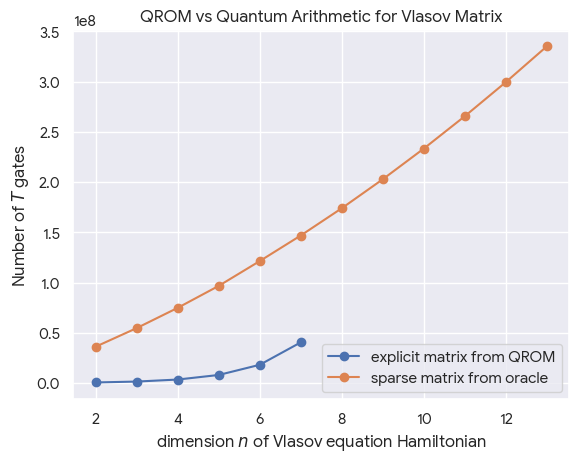

In [26]:
plt.ylabel('Number of $T$ gates')
plt.xlabel('dimension $n$ of Vlasov equation Hamiltonian')
plt.plot(range(2, 8), explicit_n, marker='o', label='explicit matrix from QROM')
plt.plot(range(2, 14), sparse_n, marker='o', label='sparse matrix from oracle')
plt.legend(loc="lower right")
plt.title('QROM vs Quantum Arithmetic for Vlasov Matrix')

The plot shows that the complexity of the block encoding of $e^{-iHt}$ scales with $O(2^n)$ when using QROM and $O(n^2)$ with quantum arithmetic. The constants for arithmetic are higher, with the cross-over point being around $n = 9$.

We can also compare the costs of the different ways of computing the Chebyshev polynomial.

In [27]:
chebyshev = chebyshev_fast
sparse_k = list(t_count(vlasov_sparse(5, K)) for K in range(2, 14))

chebyshev = chebyshev_exp
sparse0_k = list(t_count(vlasov_sparse(5, K)) for K in range(2, 7))

chebyshev = chebyshev_quad
sparse1_k = list(t_count(vlasov_sparse(5, K)) for K in range(2, 10))

Text(0.5, 1.0, 'Comparison of Chebyshev Implementations')

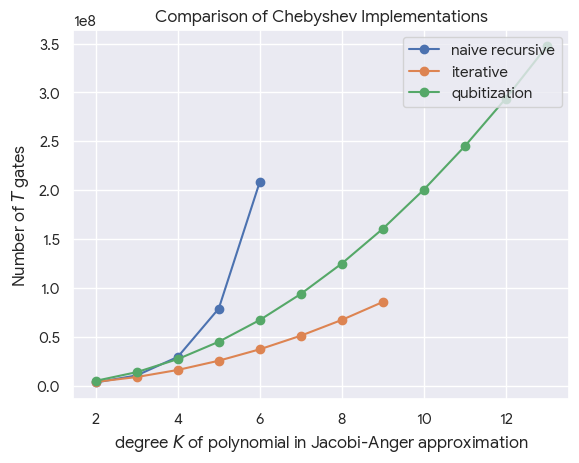

In [28]:
plt.ylabel('Number of $T$ gates')
plt.xlabel('degree $K$ of polynomial in Jacobi-Anger approximation')
plt.plot(range(2, 7), sparse0_k, marker='o', label='naive recursive')
plt.plot(range(2, 10), sparse1_k, marker='o', label='iterative')
plt.plot(range(2, 14), sparse_k, marker='o', label='qubitization')
plt.legend(loc="upper right")
plt.title('Comparison of Chebyshev Implementations')

Empirically, when using the efficient method to compute the Chebyshev polynomial, the overall complexity of the block encoding of $e^{-iHt}$ scales as $O(n^2 K^2)$. The quadratic scaling in $K$ is due to the computation of the linear combination of $K$ Chebyshev polynomials, each of which has $O(K)$ amortized complexity, in the Jacobi-Anger decomposition.

Finally, we can compare the cost of performing arithmetic over block-encoded matrices to quantum signal processing using `GeneralizedQSP`. Note that there are many caveats such as different error propagation that affect the accuracy of this comparison in general.

In [29]:
def vlasov_gqsp(n):
    row_oracle = col_oracle = SymmetricBandedRowColumnOracle(n, bandsize=1)
    entry_oracle = VlasovEntryOracle(system_bitsize=n, entry_bitsize=n + 3, alpha=alpha)
    h = SparseMatrix(row_oracle, col_oracle, entry_oracle, eps=0)
    return HamiltonianSimulationByGQSP(ChebyshevPolynomial(h, 1), t=t, precision=1e-3)

In [30]:
def t_count(bloq):
    _, sigma = bloq.call_graph(generalizer=ignore_split_join)
    return int(t_counts_from_sigma(sigma))

gqsp_n = list(t_count(vlasov_gqsp(n)) for n in range(2, 14))

Text(0.5, 1.0, 'GQSP vs Matrix Arithmetic for Vlasov Matrix')

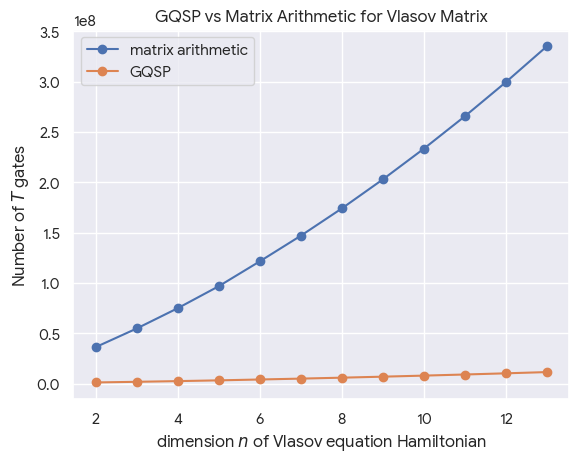

In [31]:
plt.ylabel('Number of $T$ gates')
plt.xlabel('dimension $n$ of Vlasov equation Hamiltonian')
plt.plot(range(2, 14), sparse_n, marker='o', label='matrix arithmetic')
plt.plot(range(2, 14), gqsp_n, marker='o', label='GQSP')
plt.legend(loc="upper left")
plt.title('GQSP vs Matrix Arithmetic for Vlasov Matrix')

For the polynomial in the example, QSP obtains a much more efficient circuit than explicit arithmetic over block encodings.